<h1 style="color:orange;font-size:40px;font-weight:bold">Exploration of the data</h1>

<p style="color:orange;font-size:14;font-style:italic">Through the exploration of the data, the goal is to identify the way we are going to make our study.</p>

<p style="color:orange;font-size:20;font-weight:bold">Imports of libraries</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

<p style="color:orange;font-size:20;font-weight:bold">Process of the data to make it usable</p>

In [2]:
data = pd.read_csv("data/lyrics-data.csv", usecols=["ALink", "SName", "Lyric"]) # Import the data in a pandas dataframe
data = data.rename(columns={'ALink': 'Artist', 'SName': 'Title'}) # Rename the columns
data = data.drop(data.loc[data['Lyric'].isna()].index) # Remove rows with missing values
data['Artist'] = data['Artist'].str.replace('/', '')  # Remove '/' in the name of the artist
data['Artist'] = data['Artist'].apply(lambda x: x.lower().replace('-', ' ')) # Lowerize first letter of each name, replace '-' with ' '
data = data.reset_index(drop=True) # Reset the index after removing the row
data

,Artist,Title,Lyric
0,ivete sangalo,Arerê,"Tudo o que eu quero nessa vida,\nToda vida, é\..."
1,ivete sangalo,Se Eu Não Te Amasse Tanto Assim,Meu coração\nSem direção\nVoando só por voar\n...
2,ivete sangalo,Céu da Boca,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...
3,ivete sangalo,Quando A Chuva Passar,Quando a chuva passar\n\nPra quê falar\nSe voc...
4,ivete sangalo,Sorte Grande,A minha sorte grande foi você cair do céu\nMin...
...,...,...,...
379849,clegg johnny,The Waiting,Chorus\nHere we stand waiting on the plain\nDa...
379850,clegg johnny,Too Early For The Sky,I nearly disappeared into the mouth of a croco...
379851,clegg johnny,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i..."
379852,clegg johnny,When The System Has Fallen,Sweat in the heat for days on end\nwaiting for...


<p style="color:orange;font-size:20;font-weight:bold">Description of our data</p>

In [3]:
data.describe()

,Artist,Title,Lyric
count,379854,379852,379854
unique,4238,267214,371181
top,anjos anonimos,Intro,Instrumental
freq,1029,116,2087


<p style="color:orange;font-size:20;font-weight:bold">We can see that Instrumental is a frequent term for the Lyric column. Then, we can remove all duplicates to be sure we have a unicity in the lyrics.</p>

In [4]:
data_unique = data.drop_duplicates(subset=['Lyric']) # Delete duplicates based on the Lyric column
data_unique = data_unique.reset_index(drop=True) # Reset the index after deletion

In [5]:
data_unique.describe() 

,Artist,Title,Lyric
count,371181,371179,371181
unique,4230,262367,371181
top,anjos anonimos,Intro,"Tudo o que eu quero nessa vida,\nToda vida, é\..."
freq,1029,97,1


<p style="color:orange;font-size:20;font-weight:bold">For example, Anjos Anonymos label corresponds to all the anonymous artists in the list. To be sure to conduct a good study we can select a subset of artists we know to see if our model can make the distinction between them.</p>

###### PS : Keeping all the artists could constitue an issue because of some that have only one song (no training).

In [6]:
print(f"Size of each discography :\nDrake : {len(data_unique[data_unique['Artist'] == 'drake'])}",
        f"\nKanye West : {len(data_unique[data_unique['Artist'] == 'kanye west'])}"
        f"\n50 Cent : {len(data_unique[data_unique['Artist'] == '50 cent'])}",
        f"\nTaylor Swift : {len(data_unique[data_unique['Artist'] == 'taylor swift'])}",
        f"\nCeline Dion : {len(data_unique[data_unique['Artist'] == 'celine dion'])}",
        f"\nRihanna : {len(data_unique[data_unique['Artist'] == 'rihanna'])}")

Size of each discography :
Drake : 313 
Kanye West : 292
50 Cent : 467 
Taylor Swift : 385 
Celine Dion : 399 
Rihanna : 244


<p style="color:orange;font-size:20;font-weight:bold">We can see that the artists we have chosen released a lot of songs which could be sufficient to train our model.
<br><br>I chose them because of their differences for some of them but also for their similarities. Indeed, I want to see if the model we are going to build is able to detect the subtile difference between a Kanye West song and a Drake one.</p>

In [7]:
# Liste des artistes que vous voulez garder
artists_to_keep = ["drake", "kanye west", "50 cent", "taylor swift", "celine dion", "rihanna"]

# Filtrer le DataFrame initial pour inclure uniquement les artistes spécifiques
data_unique_subset = data_unique[data_unique["Artist"].isin(artists_to_keep)]

data_unique_subset.reset_index(inplace=True, drop=True)

data_unique_subset

,Artist,Title,Lyric
0,rihanna,Love On The Brain,"And you got me, like oh\nWhat you want from me..."
1,rihanna,Umbrella (feat. Jay Z),"Jay-Z\nAham, aham... Yeah, Rihanna\nAham, aham..."
2,rihanna,Diamonds,Shine bright like a diamond\nShine bright like...
3,rihanna,Stay (feat. Mikky Ekko),All along it was a fever\nA cold sweat hot-hea...
4,rihanna,Only Girl (In The World),La la la la\nLa la la la\nLa la la la\nLa la l...
...,...,...,...
2095,celine dion,You Shook Me All Night Long,"She was a fast machine,\nShe kept the motor cl..."
2096,celine dion,Your Light,"Hey man, come over here\nThere's a secret that..."
2097,celine dion,Ziggy (english Version),"Oh\nZiggy, I call him Ziggy\nI'm so hot for hi..."
2098,celine dion,Ziggy (Un Garcon Pas Comme Les Autres),"Ziggy, il s'appelle Ziggy\nJe suis folle de lu..."


<p style="color:orange;font-size:20;font-weight:bold">The length of the lyrics can also be a good indicator to take in account for the features.</p>

In [8]:
data_unique_subset["Lyric_Length"] = data_unique_subset["Lyric"].str.len() # New column for a new feature ?
data_unique_subset

C:\Users\Amine\AppData\Local\Temp\ipykernel_138848\1756466921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique_subset["Lyric_Length"] = data_unique_subset["Lyric"].str.len() # New column for a new feature ?


,Artist,Title,Lyric,Lyric_Length
0,rihanna,Love On The Brain,"And you got me, like oh\nWhat you want from me...",1597
1,rihanna,Umbrella (feat. Jay Z),"Jay-Z\nAham, aham... Yeah, Rihanna\nAham, aham...",2565
2,rihanna,Diamonds,Shine bright like a diamond\nShine bright like...,2041
3,rihanna,Stay (feat. Mikky Ekko),All along it was a fever\nA cold sweat hot-hea...,1140
4,rihanna,Only Girl (In The World),La la la la\nLa la la la\nLa la la la\nLa la l...,1883
...,...,...,...,...
2095,celine dion,You Shook Me All Night Long,"She was a fast machine,\nShe kept the motor cl...",1256
2096,celine dion,Your Light,"Hey man, come over here\nThere's a secret that...",2032
2097,celine dion,Ziggy (english Version),"Oh\nZiggy, I call him Ziggy\nI'm so hot for hi...",995
2098,celine dion,Ziggy (Un Garcon Pas Comme Les Autres),"Ziggy, il s'appelle Ziggy\nJe suis folle de lu...",1015


In [9]:
data_unique_subset[data_unique_subset.Title.str.contains(r'\(.*\)', regex=True)]

,Artist,Title,Lyric,Lyric_Length
1,rihanna,Umbrella (feat. Jay Z),"Jay-Z\nAham, aham... Yeah, Rihanna\nAham, aham...",2565
3,rihanna,Stay (feat. Mikky Ekko),All along it was a fever\nA cold sweat hot-hea...,1140
4,rihanna,Only Girl (In The World),La la la la\nLa la la la\nLa la la la\nLa la l...,1883
5,rihanna,We Found Love (feat. Calvin Harris),Yellow diamonds in the light\nAnd we're standi...,1018
11,rihanna,Work (Feat. Drake),"Work, work, work, work\nWork, work\nYou see me...",2889
...,...,...,...,...
2059,celine dion,The Show Must Go On (feat. Lindsey Stirling),Empty spaces - what are we living for\nAbandon...,1304
2083,celine dion,Voler (Feat. Michel Sardou),Michel Sardou :\nVoler\nAu-dessus des nuages\n...,1152
2092,celine dion,Wicked Game (With Chris Isaak),The world was on fire\nand no one could save m...,1321
2097,celine dion,Ziggy (english Version),"Oh\nZiggy, I call him Ziggy\nI'm so hot for hi...",995


<p style="color:orange;font-size:20;font-weight:bold">We can see a lot of featurings but it's okay to keep them as it is because it might helps the model to make predictions. If an artist use to collaborate with another one for example. However, we will have to process the texts in Title and Lyric section to remove special characters such as parenthesis.</p>

# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

<h4 style="color:orange;font-size:40px;font-weight:bold">Charts</h4>

<p style="color:orange;font-size:20;font-weight:bold">The first chart we are going to make will allow us to explore the distribution of the length of the lyrics for each artist.<p>

C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


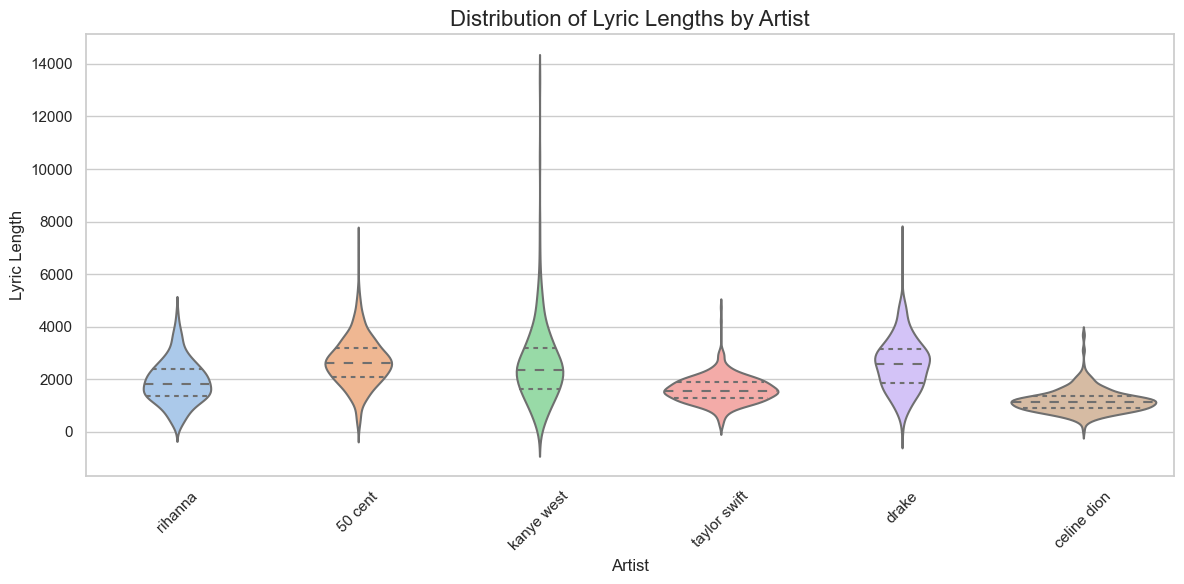

In [10]:
# Set the style and palette for the plot
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Create a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="Artist", y="Lyric_Length", data=data_unique_subset, inner="quartile")

# Set titles and labels
plt.title("Distribution of Lyric Lengths by Artist", fontsize=16)
plt.xlabel("Artist", fontsize=12)
plt.ylabel("Lyric Length", fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\Amine\AppData\Local\Temp\ipykernel_138848\190525926.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Artist", y="Lyric_Length", data=mean_lyric_length, ci=None)
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorical

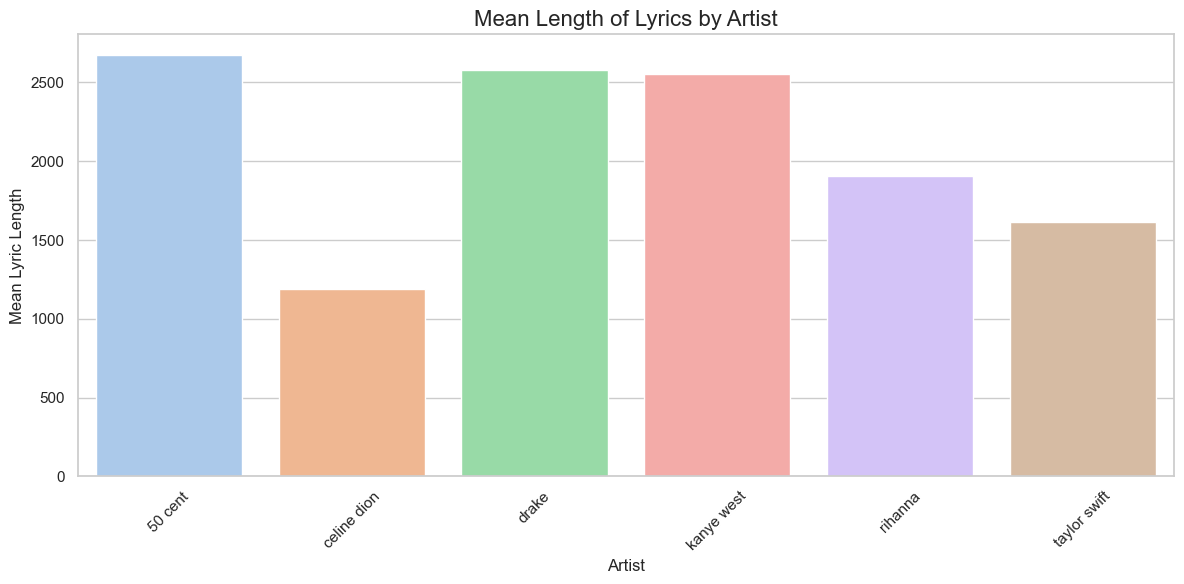

In [11]:
# Compute mean lyric length for each artist
mean_lyric_length = data_unique_subset.groupby('Artist')['Lyric_Length'].mean().reset_index()

# Set the style and palette for the plot
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Artist", y="Lyric_Length", data=mean_lyric_length, ci=None)

# Set titles and labels
plt.title("Mean Length of Lyrics by Artist", fontsize=16)
plt.xlabel("Artist", fontsize=12)
plt.ylabel("Mean Lyric Length", fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

<p style="color:orange;font-size:20;font-weight:bold">More the distribution is vertically oriented less it will help our model to predict the artist.<br><br>In contrary, if all songs of an artist were having a length between 1500 and 1600, our model would likely choose this artist and not another (additionating the weight of the lyrics and song name also).<br><br>For our sample, it seems to be the case for the artists Taylor Swift and Celine Dion (horizontally oriented).</p>

# --------------------------------------------------------------------------------------------

<p style="color:orange;font-size:24px;font-weight:bolder">Function to get the most recurrent words for an artist.</p>

In [60]:
def get_top_words_for_artist(data, artist_name, indexation):
    # Step 1: Tokenize the lyrics
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(data['Lyric'])

    # Step 2: Calculate TF-IDF scores
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    # Combine the TF-IDF scores with the original DataFrame
    tfidf_df['Artist'] = data['Artist']

    # Step 3: Get the top 5 words for each artist
    result_table = pd.DataFrame(columns=['Top', 'Word', 'Frequency'])

    for artist in tfidf_df['Artist'].unique():
        artist_df = tfidf_df[tfidf_df['Artist'] == artist]

        # Filter the DataFrame to only include the specified artist's lyrics
        if artist == artist_name:
            artist_df = artist_df[artist_df['Artist'] == artist_name]

            # Get the top 5 words based on mean TF-IDF scores for the specified artist's lyrics
            top_words = artist_df.drop('Artist', axis=1).mean().sort_values(ascending=False).head(5).index.tolist()

            # Add the top words and their frequencies to the result table
            for i, word in enumerate (top_words):
                score = artist_df.drop('Artist', axis=1).mean().loc[word]
                result_table = pd.concat([result_table, pd.DataFrame({'Top': i + 1, 'Word': word, 'Frequency': score}, index=[artist_name.title()])], ignore_index=False)
    return result_table

<p style="color:orange;font-size:24px;font-weight:bolder">Chart of Top Words By Artist Without Stopwords</p>

C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

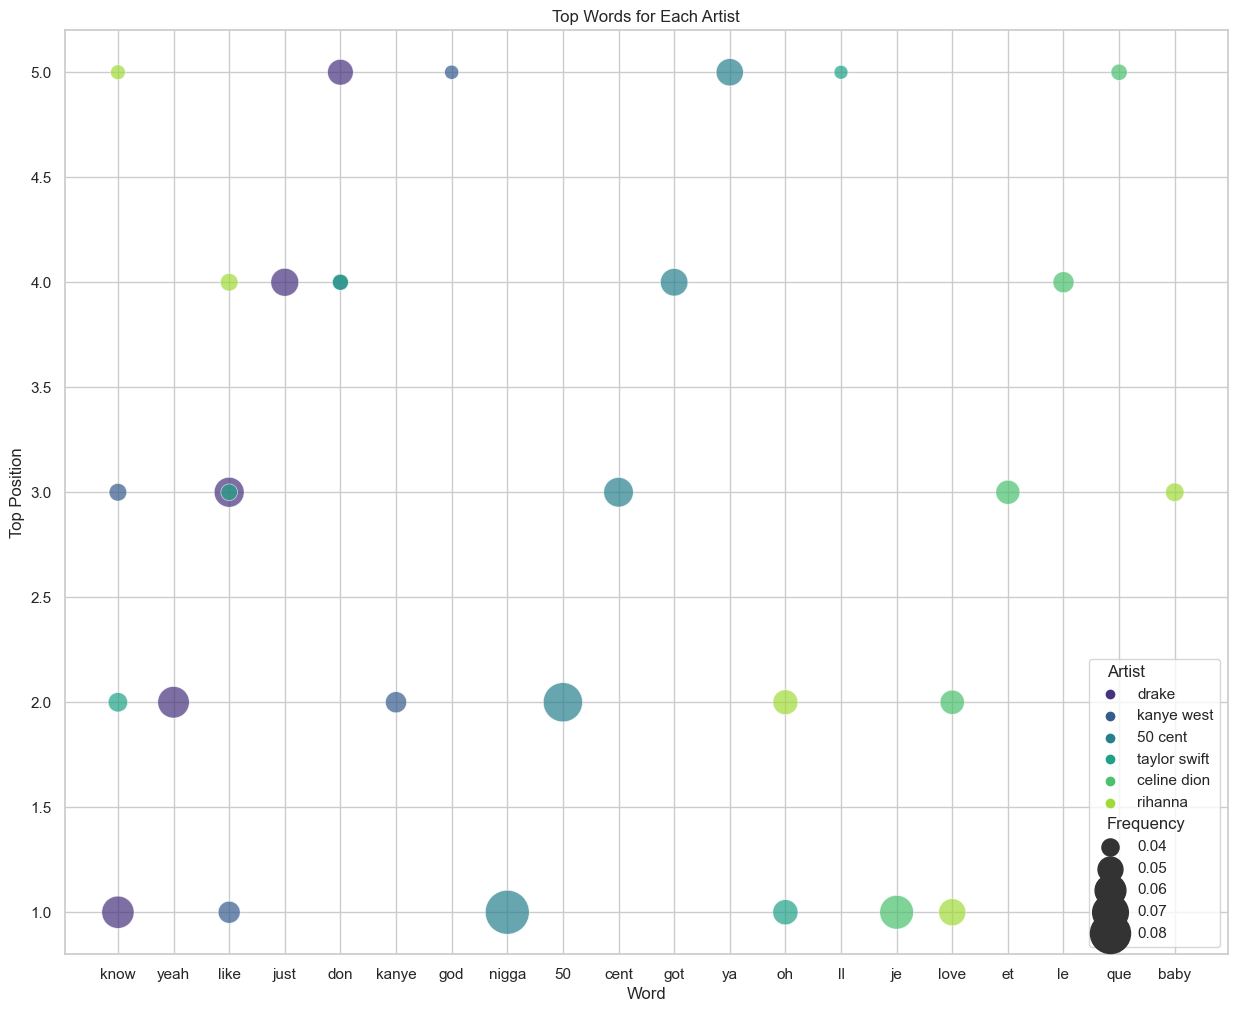

In [69]:
results = []
indexation = 0

for artist in artists_to_keep:
    results.append(get_top_words_for_artist(data_unique_subset, artist, indexation))
    indexation += 4

# Process results to create a DataFrame
result_df = pd.concat(results, keys=artists_to_keep, names=['Artist'])
# Reset the index to make 'Artist' a regular column
result_df = result_df.reset_index()

# Create a bubble chart with Seaborn
plt.figure(figsize=(15,12))
bubble_chart = sns.scatterplot(
    data=result_df,
    x='Word',
    y='Top',
    size='Frequency',
    hue='Artist',
    sizes=(100, 1000),
    palette='viridis',
    alpha=0.7,
    edgecolor='w',  # Use 'edgecolor' instead of 'edgecolors'
    linewidth=0.5
)

# Customize the chart
bubble_chart.set_title('Top Words for Each Artist')
bubble_chart.set_xlabel('Word')
bubble_chart.set_ylabel('Top Position')

# Show the chart
plt.show()

<p style="color:orange;font-size:20;font-weight:bold">We can see that there are some recurrent words like "know", "like", "oh", "love".<br><br>Then our model will have to be subtile to make the difference between the artists.<br><br>In the pre-processing pipeline, we might delete these words in the lyrics to help our model.</p>

<p style="color:orange;font-size:24px;font-weight:bolder">Chart of Most Frequent Words Among the Lyrics Data</p>

C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Amine\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

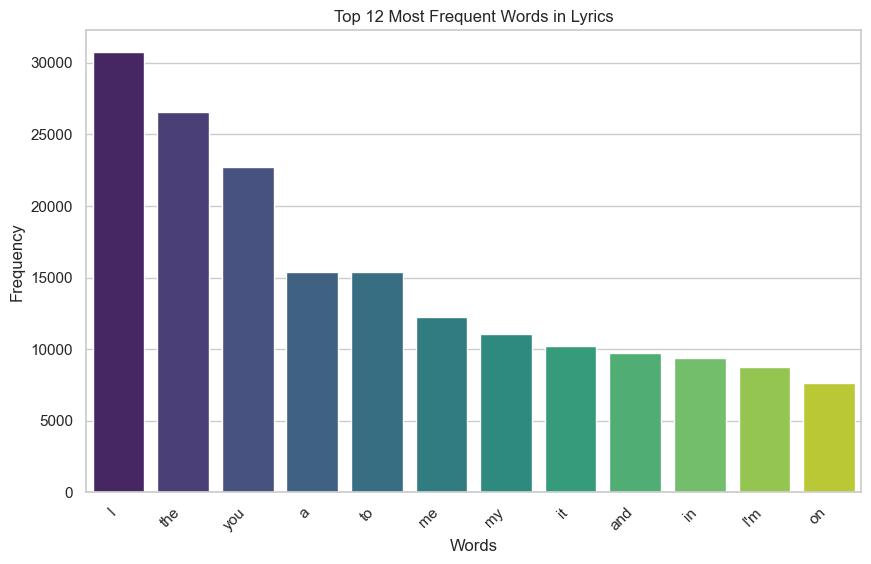

In [70]:
# Extract all lyrics into a single string
all_lyrics = ' '.join(data_unique_subset['Lyric'])

# Tokenize the combined lyrics into words
words = all_lyrics.split()

# Use Counter to count the frequency of each word
word_counter = Counter(words)

# Get the top 12 most frequent words
top_12_words = dict(word_counter.most_common(12))

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_12_words.keys()), y=list(top_12_words.values()), palette="viridis")

# Customize the plot
plt.title('Top 12 Most Frequent Words in Lyrics')
plt.xlabel('Words')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()


<p style="color:orange;font-size:20;font-weight:bold">As we've seen some words are current in the dataset. To help the model to make the difference between the lyrics of an artist and those of an other we will surely remove Stopwords and Frequent Words.</p>